In [4]:
# Cell 1: simulate tiny clustered ordinal data
import numpy as np

from pymc.exceptions            import SamplingError
from bayes_ordinal.models.cumulative     import cumulative_model
from bayes_ordinal.models.partial_odds   import partial_odds_model
from bayes_ordinal.workflow.prior_predictive      import run_prior_predictive
from bayes_ordinal.workflow.posterior_predictive  import run_posterior_predictive
from bayes_ordinal.workflow.fitting              import fit_model
from bayes_ordinal.workflow.diagnostics          import plot_group_forest

rng = np.random.default_rng(123)
n, K, G, P = 50, 4, 3, 2
X         = rng.normal(size=(n, P))
y         = rng.integers(0, K, size=n)
group_idx = rng.integers(0, G, size=n)

print("✔ Data shapes:", X.shape, y.shape, group_idx.shape)


✔ Data shapes: (50, 2) (50,) (50,)



→ cumulative[logit]


Sampling: [alpha, beta, u_offset, u_sigma, y_obs]
Only 10 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Only 10 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [alpha, beta, u_sigma, u_offset]
Sampling 1 chain for 10 tune and 10 draw iterations (10 + 10 draws total) took 0 seconds.
The number of samples is too small to check convergence reliably.
Sampling: [y_obs]


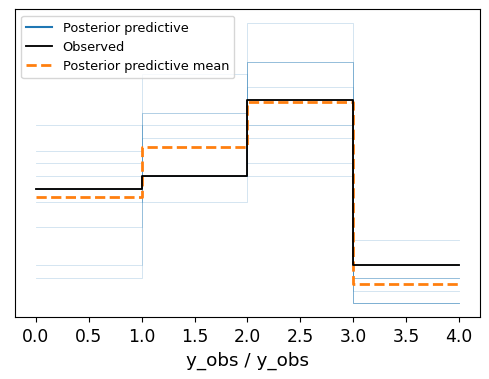

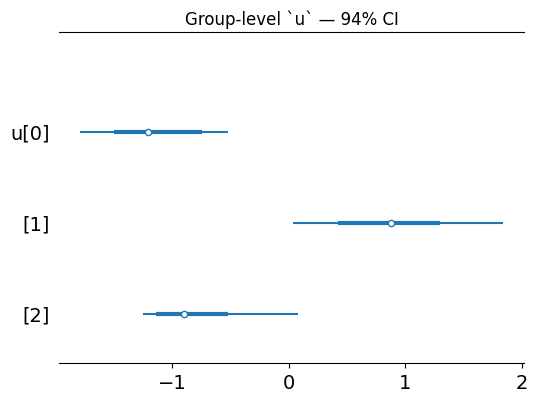


→ cumulative[probit]


Sampling: [alpha, beta, u_offset, u_sigma, y_obs]
Only 10 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Only 10 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [alpha, beta, u_sigma, u_offset]
Sampling 1 chain for 10 tune and 10 draw iterations (10 + 10 draws total) took 0 seconds.
The number of samples is too small to check convergence reliably.
Sampling: [y_obs]


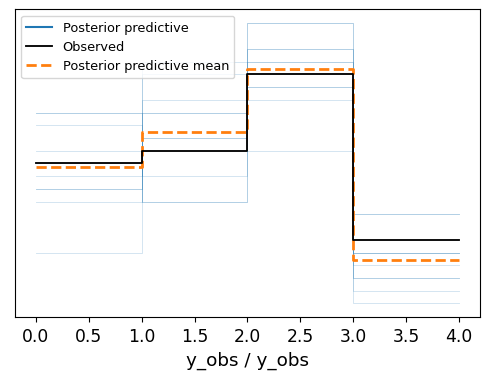

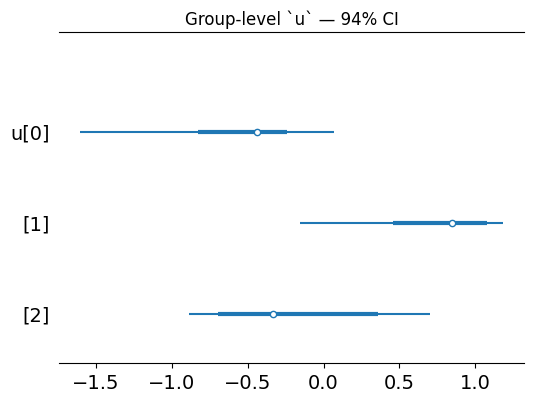

Sampling: [alpha, beta, u_offset, u_sigma, y_obs]
Only 10 samples in chain.



→ cumulative[cloglog]


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Only 10 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [alpha, beta, u_sigma, u_offset]
Sampling 1 chain for 10 tune and 10 draw iterations (10 + 10 draws total) took 0 seconds.
The number of samples is too small to check convergence reliably.
Sampling: [y_obs]


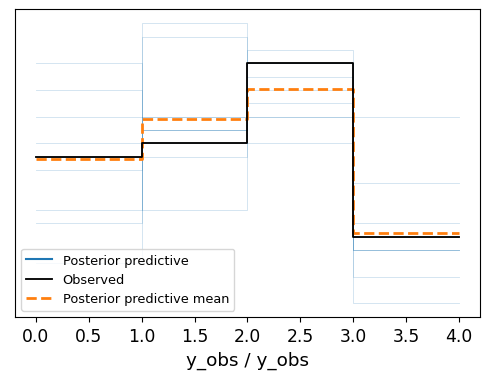

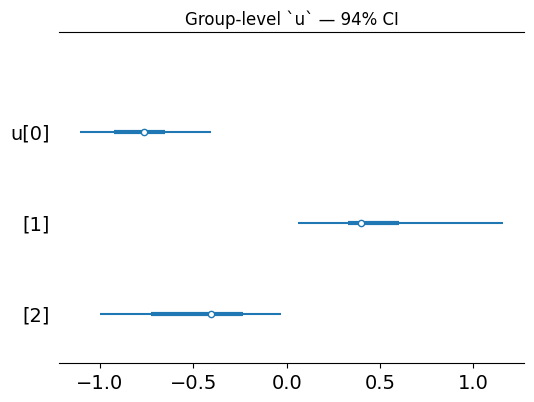


✔ cumulative_model results: {'cumulative[logit]': {'prior': True, 'sample': True}, 'cumulative[probit]': {'prior': True, 'sample': True}, 'cumulative[cloglog]': {'prior': True, 'sample': True}}


In [6]:
# Cell 2: smoke-test multilevel cumulative_model for logit, probit, cloglog
from pymc.exceptions import SamplingError

results = {}
for link in ("logit", "probit", "cloglog"):
    tag = f"cumulative[{link}]"
    print(f"\n→ {tag}")
    model = cumulative_model(
        y=y, X=X, K=K, link=link,
        group_idx=group_idx, n_groups=G
    )

    # 1) prior-predictive
    try:
        prior = run_prior_predictive(model, draws=20, plot=False)
        ok_prior = True
    except Exception as e:
        print("  ✗ prior_predictive failed:", e)
        ok_prior = False

    # 2) smoke-fit with explicit start
    ok_sample = False
    try:
        init_start = {
            "alpha":    np.linspace(-1, 1, K-1),  # cutpoints evenly spaced
            "beta":     np.zeros(X.shape[1]),     # zero slopes
            "u_offset": np.zeros(G),              # zero group offsets
            "u_sigma":  1.0,                      # moderate group SD
        }
        idata = fit_model(
            model,
            smoke_test=True,
            init="adapt_diag",                   # no jitter needed
            start=init_start,
            progressbar=False
        )
        ok_sample = True

        # 3) posterior‐predictive histogram
        _ = run_posterior_predictive(model, idata, kind="hist")

        # 4) forest plot of u
        plot_group_forest(idata, var_name="u")

    except (SamplingError, FloatingPointError) as e:
        print("  ✗ sampling or post_pred failed:", repr(e))

    results[tag] = {"prior": ok_prior, "sample": ok_sample}

print("\n✔ cumulative_model results:", results)


Sampling: [beta, gamma, u_offset, u_sigma, y_obs]
Only 10 samples in chain.



→ partial_odds


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 5900
Interrupted at 5,899 [2%]: Average Loss = 88.935
Sequential sampling (1 chains in 1 job)
NUTS: [gamma, beta, u_sigma, u_offset]
Sampling 1 chain for 10 tune and 10 draw iterations (10 + 10 draws total) took 0 seconds.
The number of samples is too small to check convergence reliably.
Sampling: [y_obs]


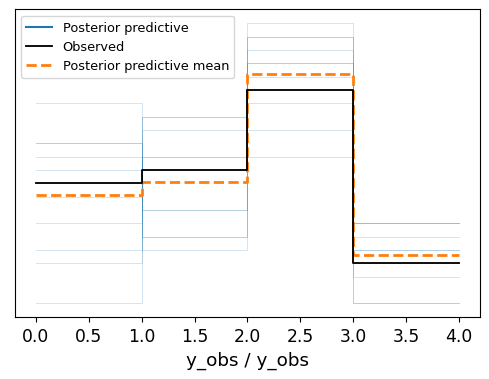

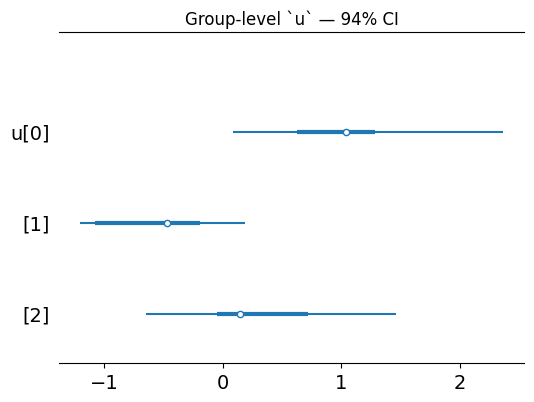


✔ partial_odds_model results: {'prior': True, 'sample': True}


In [8]:
# Cell 3: smoke-test multilevel partial_odds_model
from pymc.exceptions import SamplingError

tag = "partial_odds"
print(f"\n→ {tag}")
model_p = partial_odds_model(
    y=y, X=X, K=K,
    group_idx=group_idx, n_groups=G
)

# 1) prior‐predictive
try:
    prior_p = run_prior_predictive(model_p, draws=20, plot=False)
    ok_prior = True
except Exception as e:
    print("  ✗ prior_predictive failed:", e)
    ok_prior = False

# 2) smoke‐fit with explicit start
ok_sample = False
try:
    init_start = {
        "gamma":    np.linspace(-1, 1, K-1),  # partial‐odds intercepts
        "beta":     np.zeros(X.shape[1]),
        "u_offset": np.zeros(G),
        "u_sigma":  1.0,
    }
    idata_p = fit_model(
        model_p,
        smoke_test=True,
        init="adapt_diag",
        start=init_start,
        progressbar=False
    )
    ok_sample = True

    # 3) posterior‐predictive histogram
    _ = run_posterior_predictive(model_p, idata_p, kind="hist")

    # 4) forest plot of u
    plot_group_forest(idata_p, var_name="u")

except (SamplingError, FloatingPointError) as e:
    print("  ✗ sampling or post_pred failed:", repr(e))

results[tag] = {"prior": ok_prior, "sample": ok_sample}
print("\n✔ partial_odds_model results:", results[tag])


In [10]:
# Cell 4: final summary
import pandas as pd
print("\n✅ Summary of all smoke-tests:")
display(pd.DataFrame(results).T)



✅ Summary of all smoke-tests:


,prior,sample
cumulative[logit],True,True
cumulative[probit],True,True
cumulative[cloglog],True,True
partial_odds,True,True
